# Przewidywanie cen telefonów
W tym projekcie zajmę się przewidywaniem cen telefonów na podstawie specyfikacji technicznej. Wykorzystam w tym celu zbiór danych znaleziony na kaggle (https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification ).

In [1]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import keras
import tensorflow as tf
keras.__version__
from numpy import genfromtxt
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib
import seaborn as sn
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout
from keras_tuner.tuners import RandomSearch
from keras_tuner.tuners import Hyperband
from keras_tuner.tuners import BayesianOptimization
import time
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Analiza danych
Celem jest zaklasyfikowanie telefonu do odpowiedniej grupy cenowej 0(low cost), 1(medium cost), 2(high cost) oraz 3(very high cost).

In [4]:
datapd = pd.read_csv("/content/drive/MyDrive/projekt/data/train.csv")
m = datapd.shape[0]
n = datapd.shape[1]
print(('Ilosc danych m = %d, ilosc cech n = %d')%(m, n-1))
datapd.head()

Ilosc danych m = 2000, ilosc cech n = 20


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [5]:
datapd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

Opis danych:
- id: ID
- battery_power: Całkowita pojemność bateri w mAh
- blue: Czy posiada bluetooth
- clock_speed: szybkość mikroprocesora
- dual_sim: Czy wspiera dualsim
- fc: rozdzielczość przedniego aparatu w Mpx
- four_g: Czy ma 4g
- int_memory: Pamięć wewnętrzna w GB
- m_dep: grubość w cm
- mobile_wt: waga
- n_cores: ilość rdzeni procesora
- pc: Mpx głównego aparatu
- px_height: wysokość w px
- px_width: szerokość w px
- ram: RAM w MB
- sc_h: wysokość ekranu w cm
- sc_w: szerokość ekranu w cm
- talk_time: maksymalny czas rozmowy na jednym naładowaniu baterii
- three_g: czy ma 3g
- touch_screen: czy ma ekran dotykowy
- wifi: czy ma wifi

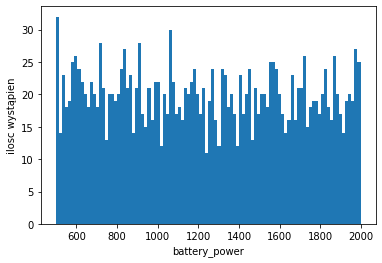

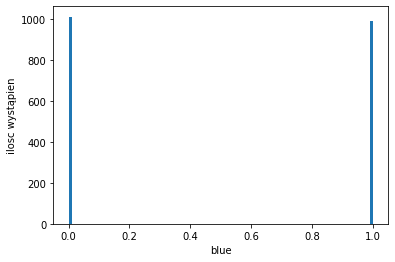

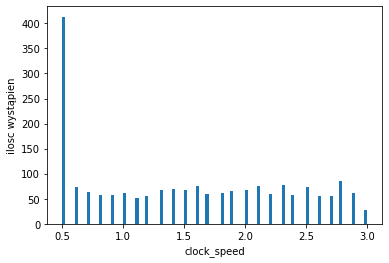

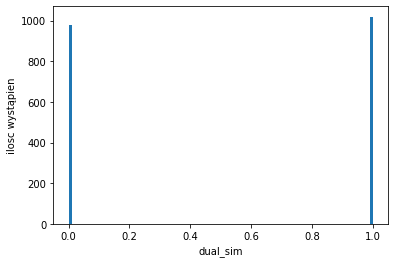

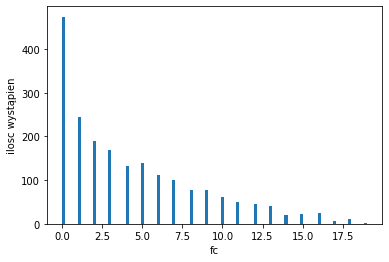

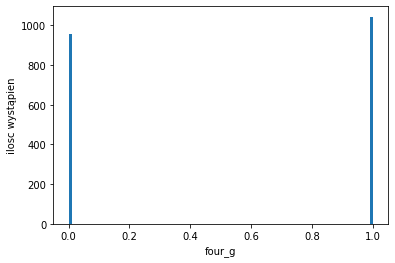

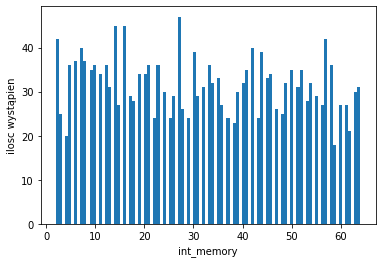

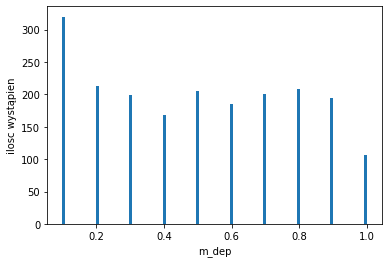

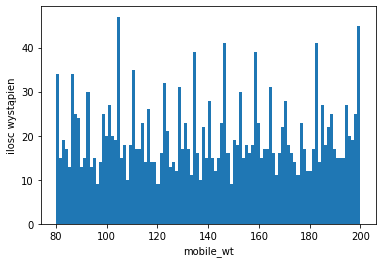

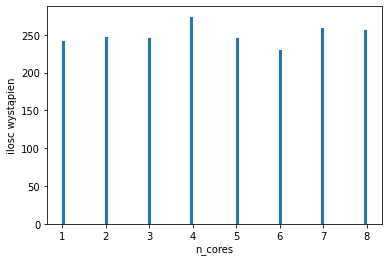

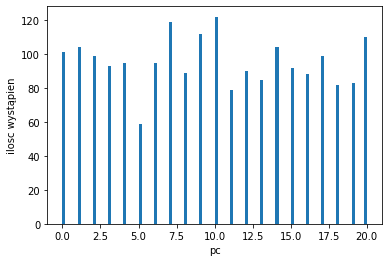

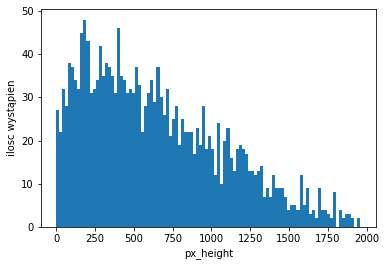

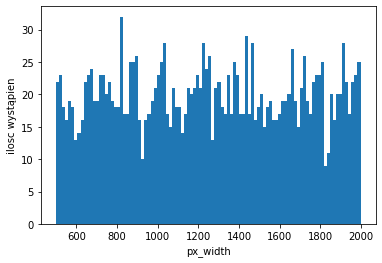

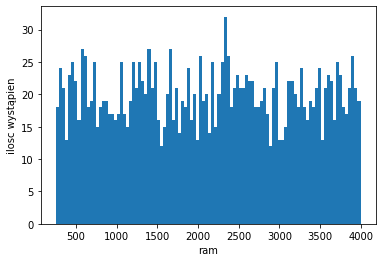

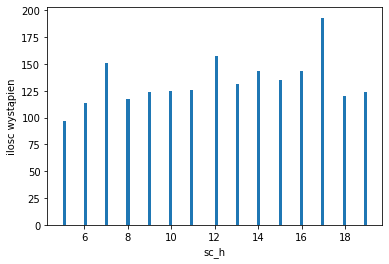

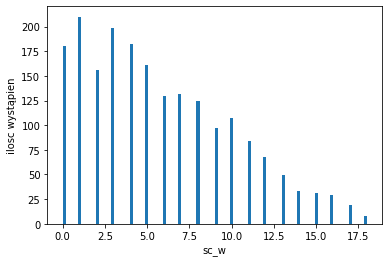

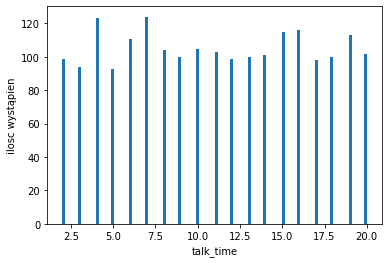

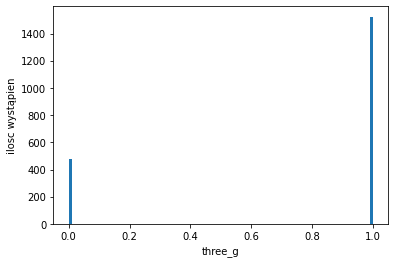

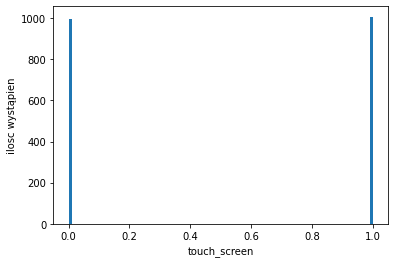

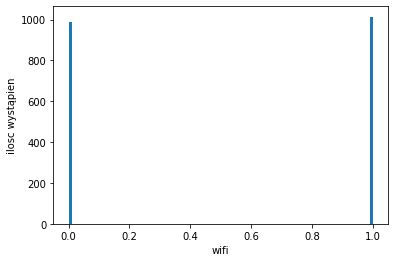

In [6]:
data_to_draw = datapd.drop(['price_range'], axis=1)
features = data_to_draw.keys()

for feature in data_to_draw.keys():
    plt.hist(data_to_draw[feature], bins=100)
    plt.ylabel('ilosc wystąpien')
    plt.xlabel(feature)
    plt.show()

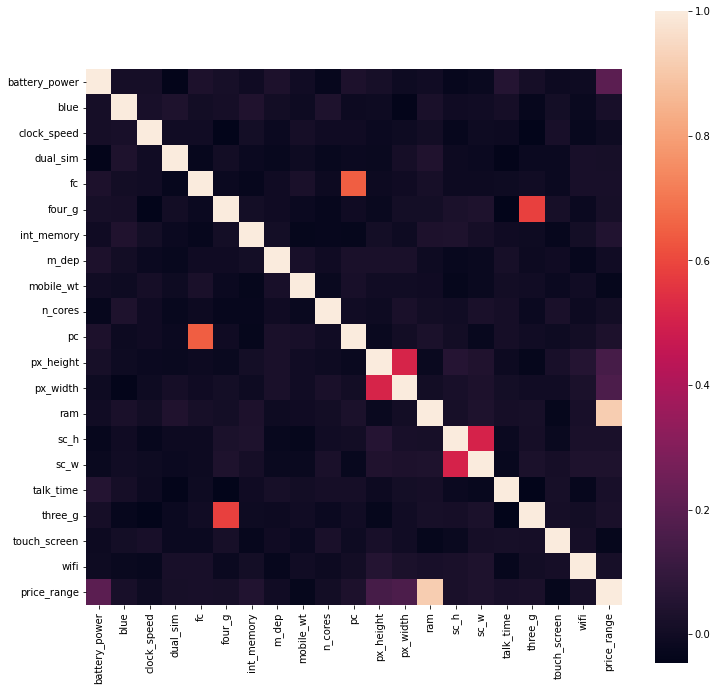

In [7]:
fig = plt.figure(figsize=(12, 12))
corrmat = datapd.corr()
sn.heatmap(corrmat, square=True)
plt.show()

Możemy zauważyć silną korelację ram i price_range

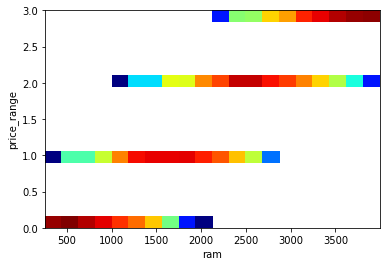

In [8]:
plt.hist2d(datapd['ram'], datapd['price_range'], bins=20, cmap = 'jet', norm = matplotlib.colors.LogNorm())
plt.xlabel("ram")
plt.ylabel("price_range")
plt.show()

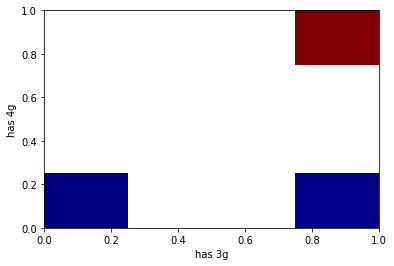

In [9]:
plt.hist2d(datapd['three_g'], datapd['four_g'], bins=4, cmap = 'jet', norm = matplotlib.colors.LogNorm())
plt.xlabel("has 3g")
plt.ylabel("has 4g")
plt.show()

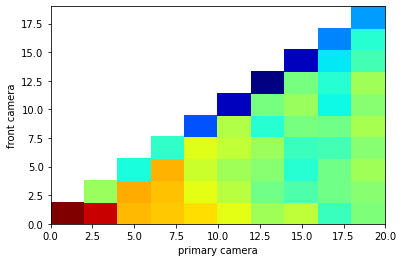

In [10]:
plt.hist2d(datapd['pc'], datapd['fc'], bins=10, cmap = 'jet', norm = matplotlib.colors.LogNorm())
plt.xlabel("primary camera")
plt.ylabel("front camera")
plt.show()

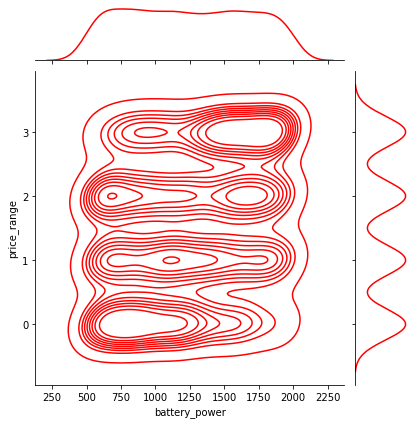

In [11]:
sn.jointplot(x='battery_power', y='price_range', data=datapd, color='red', kind='kde')

# Przekształcanie danych
Pierwszym krokiem będzie przekształcenie pól px_width oraz px_height w pole resolution, które wyraża rozdzielczość ekranu w Mpx

In [12]:
datapd['resolution'] = datapd['px_height'] * datapd['px_width'] / 1_000_000

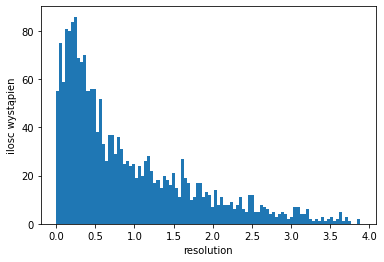

In [13]:
plt.hist(datapd['resolution'], bins=100)
plt.ylabel('ilosc wystąpien')
plt.xlabel('resolution')
plt.show()

W kolejnym kroku przekształcam szerokość i wysokość ekranu w jedno pole - przekątną

In [14]:
datapd['diagonal'] = (datapd['sc_w'] ** 2 + datapd['sc_h'] ** 2) ** (1/2)

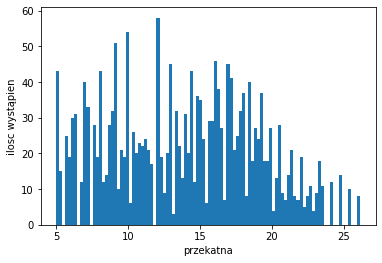

In [15]:
plt.hist(datapd['diagonal'], bins=100)
plt.ylabel('ilosc wystąpien')
plt.xlabel('przekatna')
plt.show()

Na koniec usuwam niepotrzebne kolumny

In [16]:
datapd = datapd.drop(['px_width', 'px_height', 'sc_w', 'sc_h'], axis=1)

In [17]:
datapd.shape

(2000, 19)

In [18]:
X, y = np.array(datapd.drop('price_range', axis=1)), np.array(datapd['price_range'])
y = to_categorical(y)
print(X.shape, y.shape)

(2000, 18) (2000, 4)


In [19]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [20]:
x_train.shape, x_test.shape

((1600, 18), (400, 18))

# Standaryzacja

In [21]:
mean = x_train.mean()
std = x_train.std()

In [22]:
x_train -= mean
x_test -= mean

x_train /= std
x_test /= std

# Budowa modelu sieci

In [23]:
#tutaj wpisz kod
def build_model(hp):
    #initialize Sequential model
    model = keras.models.Sequential()
    
    #add first layer
    model.add(Dense(hp.Int('input_units',
                                min_value=2,
                                max_value=128,
                                step=16),
                    activation=hp.Choice(
                               'dense-activation_0',
                               values=['tanh', 'relu', 'sigmoid'],
                               default='relu'
                           ), 
                    input_shape=(x_train.shape[1], )))
    
    #add first dropout
    model.add(Dropout(rate=hp.Float(
        'dropout_0',
        min_value=0.0,
        max_value=0.5,
        step=0.05
    )))
    
    #add rest of hidden layers
    for i in range(hp.Int('n_layers', 1, 10)):
        model.add(Dense(hp.Int('hidden_units',
                                min_value=2,
                                max_value=128,
                                step=16),
                               activation=hp.Choice(
                               f'dense-activation_{i+1}',
                               values=['tanh', 'relu', 'sigmoid', 'softmax'],
                               default='relu')))
        
        model.add(Dropout(rate=hp.Float(
                  f'dropout_{i+1}',
                  min_value=0.0,
                  max_value=0.5,
                  default=0.25,
                  step=0.05)))
    
    #add last layer
    model.add(Dense(4, activation='softmax'))
    
    #compile the model
    optimizers=[keras.optimizers.Adam, keras.optimizers.sgd_experimental.SGD, keras.optimizers.rmsprop_experimental.RMSprop]
    model.compile(optimizer=optimizers[hp.Int('optimizer', min_value=0, max_value=2)]\
                 (hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)), 
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Tuning hiperparametrów

In [24]:
# LOG_DIR = f"{/content/drive/MyDrive/projekt/int(time.time())}"
# tuner = RandomSearch(
#     build_model,
#     objective='accuracy',
#     max_trials=1_000,  # ile roznych modeli przetestowac?
#     executions_per_trial=1, 
#     directory=LOG_DIR)

In [26]:
LOG_DIR_BO = "/content/drive/MyDrive/projekt/BO_"+f"123"
tuner = BayesianOptimization (
    build_model,
    objective='accuracy',
    max_trials = 200,
    directory=LOG_DIR_BO,
    project_name='drugi')

In [27]:
tuner.search(x=x_train,
             y=y_train,
             verbose=2, 
             epochs=10,
             batch_size=16,
             validation_split = 0)

Trial 200 Complete [00h 00m 04s]
accuracy: 0.7306249737739563

Best accuracy So Far: 0.8324999809265137
Total elapsed time: 00h 48m 19s


# Najlepszy model

In [28]:
tuner.get_best_hyperparameters()[0].values

{'input_units': 114,
 'dense-activation_0': 'tanh',
 'dropout_0': 0.0,
 'n_layers': 1,
 'hidden_units': 114,
 'dense-activation_1': 'tanh',
 'dropout_1': 0.0,
 'optimizer': 2,
 'learning_rate': 0.0003079288664342074,
 'dense-activation_2': 'tanh',
 'dropout_2': 0.0,
 'dense-activation_3': 'softmax',
 'dropout_3': 0.25,
 'dense-activation_4': 'relu',
 'dropout_4': 0.45,
 'dense-activation_5': 'tanh',
 'dropout_5': 0.45,
 'dense-activation_6': 'softmax',
 'dropout_6': 0.0,
 'dense-activation_7': 'relu',
 'dropout_7': 0.35000000000000003,
 'dense-activation_8': 'softmax',
 'dropout_8': 0.0,
 'dense-activation_9': 'relu',
 'dropout_9': 0.45,
 'dense-activation_10': 'tanh',
 'dropout_10': 0.0}

In [29]:
super_model = tuner.get_best_models()[0]
super_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 114)               2166      
                                                                 
 dropout (Dropout)           (None, 114)               0         
                                                                 
 dense_1 (Dense)             (None, 114)               13110     
                                                                 
 dropout_1 (Dropout)         (None, 114)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 460       
                                                                 
Total params: 15,736
Trainable params: 15,736
Non-trainable params: 0
_________________________________________________________________


In [68]:
history = super_model.fit(x=x_train,y=y_train,verbose=2, epochs=10, batch_size=32, validation_split = 0.1)

Epoch 1/10
45/45 - 0s - loss: 0.3805 - accuracy: 0.8271 - val_loss: 0.4046 - val_accuracy: 0.8188 - 271ms/epoch - 6ms/step
Epoch 2/10
45/45 - 0s - loss: 0.3796 - accuracy: 0.8285 - val_loss: 0.3975 - val_accuracy: 0.8250 - 154ms/epoch - 3ms/step
Epoch 3/10
45/45 - 0s - loss: 0.3803 - accuracy: 0.8215 - val_loss: 0.4101 - val_accuracy: 0.8313 - 141ms/epoch - 3ms/step
Epoch 4/10
45/45 - 0s - loss: 0.3814 - accuracy: 0.8229 - val_loss: 0.4028 - val_accuracy: 0.8188 - 142ms/epoch - 3ms/step
Epoch 5/10
45/45 - 0s - loss: 0.3798 - accuracy: 0.8167 - val_loss: 0.4100 - val_accuracy: 0.8313 - 167ms/epoch - 4ms/step
Epoch 6/10
45/45 - 0s - loss: 0.3787 - accuracy: 0.8250 - val_loss: 0.4196 - val_accuracy: 0.8250 - 152ms/epoch - 3ms/step
Epoch 7/10
45/45 - 0s - loss: 0.3782 - accuracy: 0.8229 - val_loss: 0.4289 - val_accuracy: 0.8375 - 152ms/epoch - 3ms/step
Epoch 8/10
45/45 - 0s - loss: 0.3776 - accuracy: 0.8285 - val_loss: 0.4217 - val_accuracy: 0.8313 - 155ms/epoch - 3ms/step
Epoch 9/10
45/45

# Ewaluacja na zbiorze testowym

In [69]:
test_loss, test_acc = super_model.evaluate(x_test, y_test)
print("Skutecznosc SUPERMODELU na zbiorze testowym wynosi: {0:2.2f}".format(test_acc*100))

13/13 [==============================] - 0s 3ms/step - loss: 0.3833 - accuracy: 0.8250
Skutecznosc SUPERMODELU na zbiorze testowym wynosi: 82.50


# Analiza wyników

In [70]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

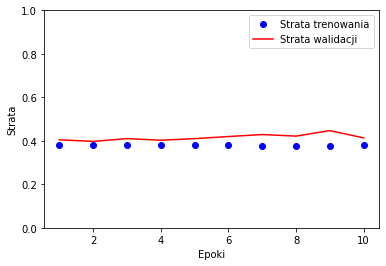

In [71]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Strata trenowania')

plt.plot(epochs, val_loss, 'r', label='Strata walidacji')

plt.ylim((0, 1))

plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

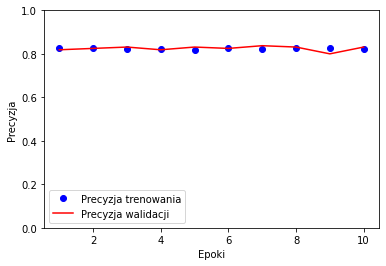

In [72]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Precyzja trenowania')

plt.plot(epochs, val_acc, 'r', label='Precyzja walidacji')

plt.ylim((0, 1))

plt.xlabel('Epoki')
plt.ylabel('Precyzja')
plt.legend()
plt.show()

In [73]:
y_pred = super_model.predict(x_test)

13/13 [==============================] - 0s 2ms/step


In [74]:
y_pred = np.argmax(y_pred, axis=1)
y_expected = np.argmax(y_test, axis=1)

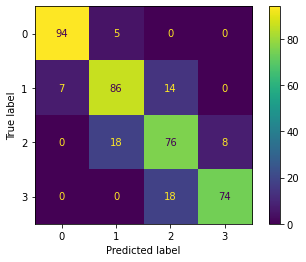

In [75]:
matr = confusion_matrix(y_expected, y_pred)
disp = ConfusionMatrixDisplay(matr)

disp.plot()